# OrgaTuring: AI Deciphers Organoids towards Futurizing Healthcare 

- CNN with Interpretability Pipeline to localize, quantize, and classify Organoid Inflamed and Non-Inflamed images

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

for d in devices:
    t = d.device_type
    name = d.physical_device_desc
    l = [item.split(':',1) for item in name.split(", ")]
    name_attr = dict([x for x in l if len(x)==2])
    dev = name_attr.get('name', 'Unnamed device')
    print(f" {d.name} || {dev} || {t} || {sizeof_fmt(d.memory_limit)}")

 /device:CPU:0 || Unnamed device || CPU || 256.0 MiB
 /device:XLA_CPU:0 || Unnamed device || XLA_CPU || 16.0 GiB
 /device:XLA_GPU:0 || Unnamed device || XLA_GPU || 16.0 GiB
 /device:XLA_GPU:1 || Unnamed device || XLA_GPU || 16.0 GiB
 /device:XLA_GPU:2 || Unnamed device || XLA_GPU || 16.0 GiB
 /device:XLA_GPU:3 || Unnamed device || XLA_GPU || 16.0 GiB
 /device:GPU:0 ||  GeForce GTX 1080 Ti || GPU || 220.1 MiB
 /device:GPU:1 ||  GeForce GTX 1080 Ti || GPU || 9.9 GiB
 /device:GPU:2 ||  GeForce GTX 1080 Ti || GPU || 9.9 GiB
 /device:GPU:3 ||  GeForce GTX 1080 Ti || GPU || 9.9 GiB


2022-09-22 00:04:24.497213: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-09-22 00:04:24.537399: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 3499710000 Hz
2022-09-22 00:04:24.538779: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56039cb60e30 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-09-22 00:04:24.538828: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-09-22 00:04:24.543240: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-09-22 00:04:25.198421: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56039cc3b3a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-09-22 00:04:25.198463: I tensor

In [3]:
#import packages
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
import splitfolders
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os
import sklearn

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

import glob
import cv2

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')


In [4]:
IMG_SIZE = 224
BATCH = 32
SEED = 42
# GPUS = ["GPU:0", "GPU:1", "GPU:2","GPU:3"]

In [5]:
# strategy = tf.distribute.MirroredStrategy(GPUS)
# print('Number of devices: %d' % strategy.num_replicas_in_sync) 

- Splitting the Dataset into train, test, and valid

In [6]:
# # Creating Train, Test, and Valid Dataset
# input_folder = "../../../aman/Updated_Dataset_2D/Sorted/"


In [7]:
# # Split with a ratio.

# # To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
# # Train, val, test
# splitfolders.ratio(input_folder, output="./dataset/", 
#                    seed=42, ratio=(.7, .2, .1), 
#                    group_prefix=None) # default values

In [8]:
train_dir = os.path.join("./dataset/new_aug_dataset/train/")
valid_dir = os.path.join('./dataset/new_aug_dataset/val/')
test_dir = os.path.join('./dataset/new_aug_dataset/test/')

train_i_dir = os.path.join('./dataset/new_aug_dataset/train/Inflamed/')
train_ni_dir = os.path.join('./dataset/new_aug_dataset/train/NonInflamed/')

valid_i_dir = os.path.join('./dataset/new_aug_dataset/val/Inflamed/')
valid_ni_dir = os.path.join('./dataset/new_aug_dataset/val/NonInflamed')

test_i_dir = os.path.join('./dataset/new_aug_dataset/test/Inflamed/')
test_ni_dir = os.path.join('./dataset/new_aug_dataset/test/NonInflamed')

In [9]:
train_i_names = os.listdir(train_i_dir)
print(train_i_names [:10])

train_ni_names  = os.listdir(train_ni_dir)
print(train_ni_names [:10])

valid_i_names = os.listdir(valid_i_dir)
print(valid_i_names[:10])

valid_ni_names = os.listdir(valid_ni_dir)
print(valid_ni_names[:10])

test_i_names = os.listdir(test_i_dir)
print(test_i_names[:10])

test_ni_names = os.listdir(test_ni_dir)
print(test_ni_names[:10])

['CD11 IL-I-QS_2496 20x 190603_0_8109.tif', 'CD11-Il-I_QS_2470_0_8255.tif', 'CD62-I-I P3 200311 4X_0_6247.tif', 'CD13-Il-I_QS_2479_0_7970.tif', 'CD41-I-I p3 10x 9-19-19_0_3677.tif', 'CD11 IL-I-QS_2501 40x 190603_0_3807.tif', 'CD63-I-I P4 200325 4X_0_2796.tif', 'CD13-Il-I_QS_2477_0_1462.tif', 'CD42-I-I P0 190905 4x _0_1927.tif', 'CD11 ILEUM I _0_9593.tif']
['CD11-LC-NI P12 190905 4x.tif', 'CD28-R-NI P0 190701 10x_0_5876.tif', 'CD47-I-NI P5 191115 4X_0_7696.tif', 'CD28-R-NI P2 190707 10X_0_7199.tif', 'CD47-LC-NI P3 191023 10X_0_7837.tif', 'CD24-I-NI P1 190620 4X.tif', 'CD50-I-NI P3 191212 4X_0_862.tif', 'CD20-I-NI P7 190729 4x_0_8158.tif', 'CD60-LC p2 5x 012720_0_9664.tif', 'CD30-I-NI P3 190805 10X_0_8651.tif']
['CD11 IL-I-QS_2497 20x 190603_0_3336.tif', 'CD11 IL-I-QS_2497 20x 190603_0_9838.tif', 'CD63-I-I P3 200318 4X_0_2713.tif', 'CD11 IL-I-QS_2500 40x 190603_0_7359.tif', 'CD11 IL-I-QS_2497 20x 190603_0_3398.tif', 'CD62-I-I P1 202026 10X_0_6212.tif', 'CD42-I-I P2 190920 4X_0_3345.tif',

In [10]:
print('total training i images:', len(os.listdir(train_i_dir)))
print('total training ni images:', len(os.listdir(train_ni_dir)))
print('total validation i images:', len(os.listdir(valid_i_dir)))
print('total validation ni images:', len(os.listdir(valid_ni_dir)))
print('total testing i images:', len(os.listdir(test_i_dir)))
print('total testing ni images:', len(os.listdir(test_ni_dir)))

num_train_i =  len(os.listdir(train_i_dir))
num_train_ni =  len(os.listdir(train_ni_dir))
num_val_i =  len(os.listdir(valid_i_dir))
num_val_ni =  len(os.listdir(valid_ni_dir))
num_test_i =  len(os.listdir(test_i_dir))
num_test_ni =  len(os.listdir(test_ni_dir))

total_train =num_train_i  + num_train_ni
total_val = num_val_i  + num_val_ni
total_test = num_test_i   + num_test_ni 

print("-----------------------------------------------------")
print("Total training images:", total_train)
print("Total validation images:", total_val)
print("Total testing images:", total_test)

total training i images: 1493
total training ni images: 1505
total validation i images: 420
total validation ni images: 422
total testing i images: 227
total testing ni images: 228
-----------------------------------------------------
Total training images: 2998
Total validation images: 842
Total testing images: 455


In [11]:
train_i = glob.glob(train_i_dir+"/*.*")
train_ni = glob.glob(train_ni_dir+"/*.*")
# train_i_names

In [12]:
valid_i = glob.glob(valid_i_dir+"/*.*")
valid_ni = glob.glob(valid_ni_dir+"/*.*")
# train_i_names

In [13]:
test_i = glob.glob(test_i_dir+"/*.*")
test_ni = glob.glob(test_ni_dir+"/*.*")
# train_i_names

In [14]:
train_list = [x for x in train_i]
train_list.extend([x for x in train_ni])

df_train = pd.DataFrame(np.concatenate([['Inflamed']*len(train_i) , ['NonInflamed']*len(train_ni)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

In [15]:
valid_list = [x for x in valid_i]
valid_list.extend([x for x in valid_ni])

df_valid = pd.DataFrame(np.concatenate([['Inflamed']*len(valid_i) , ['NonInflamed']*len(valid_ni)]), columns = ['class'])
df_valid['image'] = [x for x in valid_list]

In [16]:
test_list = [x for x in test_i]
test_list.extend([x for x in test_ni])

df_test = pd.DataFrame(np.concatenate([['Inflamed']*len(test_i) , ['NonInflamed']*len(test_ni)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [17]:
df_train

,class,image
0,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD11 IL-I-QS_2496 20x 190603_0_8109.tif
1,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD11-Il-I_QS_2470_0_8255.tif
2,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD62-I-I P3 200311 4X_0_6247.tif
3,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD13-Il-I_QS_2479_0_7970.tif
4,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD41-I-I p3 10x 9-19-19_0_3677.tif
...,...,...
2993,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD20-LC-NI P7 190801 4X_0_9237.tif
2994,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD63-LC-NI P5 200323 10X_0_4659.tif
2995,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD42-R p3 9.14.19 10x_0_4453.tif
2996,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD42-R-NI P6 191003 10X 3_0_5781.tif


In [18]:
class_i = df_train[df_train['class'] == 'Inflamed']
class_ni = df_train[df_train['class'] == 'NonInflamed']


In [19]:
class_i

,class,image
0,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD11 IL-I-QS_2496 20x 190603_0_8109.tif
1,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD11-Il-I_QS_2470_0_8255.tif
2,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD62-I-I P3 200311 4X_0_6247.tif
3,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD13-Il-I_QS_2479_0_7970.tif
4,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD41-I-I p3 10x 9-19-19_0_3677.tif
...,...,...
1488,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD11-Il-I_QS_2470_0_9548.tif
1489,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD 11 ILEUM_0_6516.tif
1490,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD42-I-I P2 190920 10X_0_9741.tif
1491,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD 11 ILEUM_0_2267.tif


In [20]:
class_ni

,class,image
1493,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD11-LC-NI P12 190905 4x.tif
1494,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD28-R-NI P0 190701 10x_0_5876.tif
1495,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD47-I-NI P5 191115 4X_0_7696.tif
1496,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD28-R-NI P2 190707 10X_0_7199.tif
1497,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD47-LC-NI P3 191023 10X_0_7837.tif
...,...,...
2993,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD20-LC-NI P7 190801 4X_0_9237.tif
2994,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD63-LC-NI P5 200323 10X_0_4659.tif
2995,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD42-R p3 9.14.19 10x_0_4453.tif
2996,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD42-R-NI P6 191003 10X 3_0_5781.tif


In [21]:
# # Convert parts into NumPy arrays for weight computation
# i_numpy = class_i['class'].to_numpy()
# ni_numpy = class_ni['class'].to_numpy()


In [22]:
# all_together = np.concatenate((i_numpy, ni_numpy))
# unique_classes = np.unique(all_together)

In [23]:
# weights = class_weight.compute_class_weight('balanced', unique_classes, all_together)
# print(weights)

In [24]:
# class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(all_together), y = all_together )

In [25]:
# class_weights = dict(enumerate(class_weights))

In [26]:
# class_weights

In [27]:
df_valid

,class,image
0,Inflamed,./dataset/new_aug_dataset/val/Inflamed/CD11 IL-I-QS_2497 20x 190603_0_3336.tif
1,Inflamed,./dataset/new_aug_dataset/val/Inflamed/CD11 IL-I-QS_2497 20x 190603_0_9838.tif
2,Inflamed,./dataset/new_aug_dataset/val/Inflamed/CD63-I-I P3 200318 4X_0_2713.tif
3,Inflamed,./dataset/new_aug_dataset/val/Inflamed/CD11 IL-I-QS_2500 40x 190603_0_7359.tif
4,Inflamed,./dataset/new_aug_dataset/val/Inflamed/CD11 IL-I-QS_2497 20x 190603_0_3398.tif
...,...,...
836,NonInflamed,./dataset/new_aug_dataset/val/NonInflamed/CD51-R-NI P7 200116 10X_0_2108.tif
837,NonInflamed,./dataset/new_aug_dataset/val/NonInflamed/CD28-R-NI P1 190707 10x .tif
838,NonInflamed,./dataset/new_aug_dataset/val/NonInflamed/CD20-I-NI P9 190806 4X_0_682.tif
839,NonInflamed,./dataset/new_aug_dataset/val/NonInflamed/CD12 IL-NI-QS_2512 40x 190603_0_5275.tif


In [28]:
df_test

,class,image
0,Inflamed,./dataset/new_aug_dataset/test/Inflamed/CD11 IL-I-QS_2493 10x 190603_0_8757.tif
1,Inflamed,./dataset/new_aug_dataset/test/Inflamed/CD11 IL-I-QS_2499 20x 190603_0_8721.tif
2,Inflamed,./dataset/new_aug_dataset/test/Inflamed/CD11 ILEUM Inf 2_0_6037.tif
3,Inflamed,./dataset/new_aug_dataset/test/Inflamed/CD11 ILEUM Inf 2_0_4410.tif
4,Inflamed,./dataset/new_aug_dataset/test/Inflamed/CD11-I-I P8 190719 4X_0_2160.tif
...,...,...
449,NonInflamed,./dataset/new_aug_dataset/test/NonInflamed/CD60-LC-NI P2 10x 200204_0_8079.tif
450,NonInflamed,./dataset/new_aug_dataset/test/NonInflamed/CD23-LC-NI P4 190805 10X_0_1991.tif
451,NonInflamed,./dataset/new_aug_dataset/test/NonInflamed/CD50-R-NI P0 191119 4X_0_5509.tif
452,NonInflamed,./dataset/new_aug_dataset/test/NonInflamed/CD62-R-NI P4 200313 10X_0_5159.tif


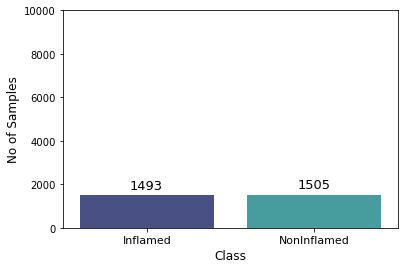

In [29]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_train, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("No of Samples", fontsize= 12)
plt.ylim(0,10000)
plt.xticks([0,1], ['Inflamed', 'NonInflamed'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()

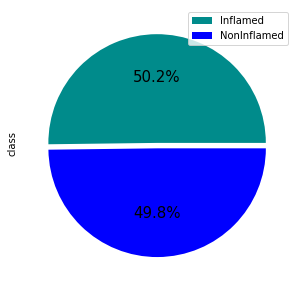

In [30]:
plt.figure(figsize=(7,5))

df_train['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Inflamed', 'NonInflamed'])
plt.show()

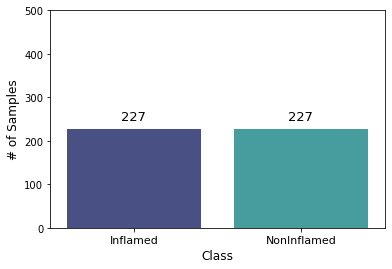

In [31]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_test, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,500)
plt.xticks([0,1], ['Inflamed', 'NonInflamed'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.32, p.get_height()+20), fontsize = 13)
    
plt.show()

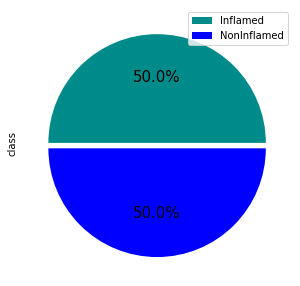

In [32]:
plt.figure(figsize=(7,5))

df_test['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Inflamed', 'NonInflamed'])
plt.show()

Train Set - Inflamed


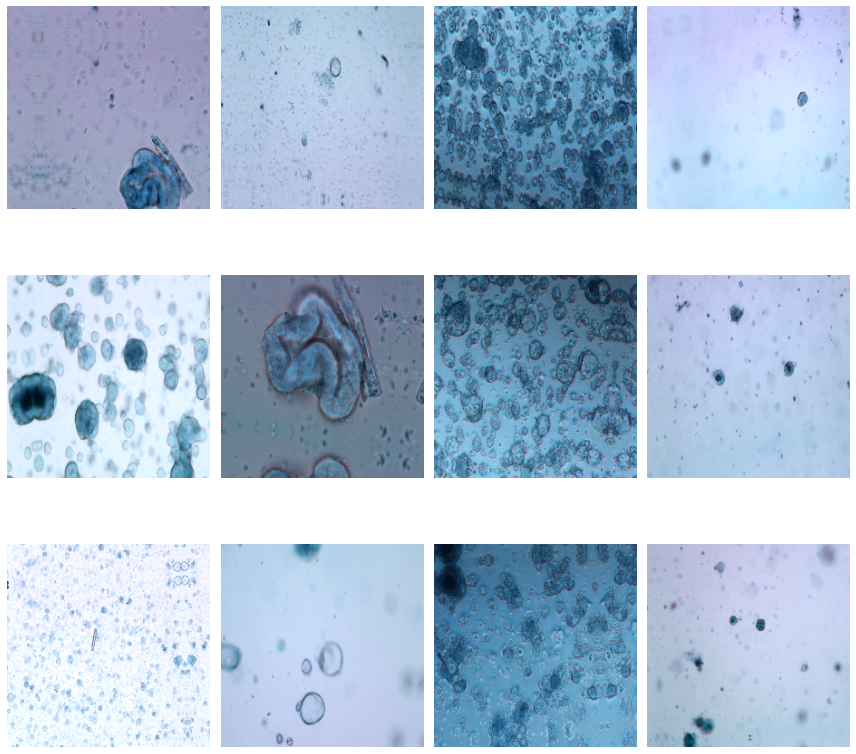

In [33]:
print('Train Set - Inflamed')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_i[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Train Set - NonInflamed


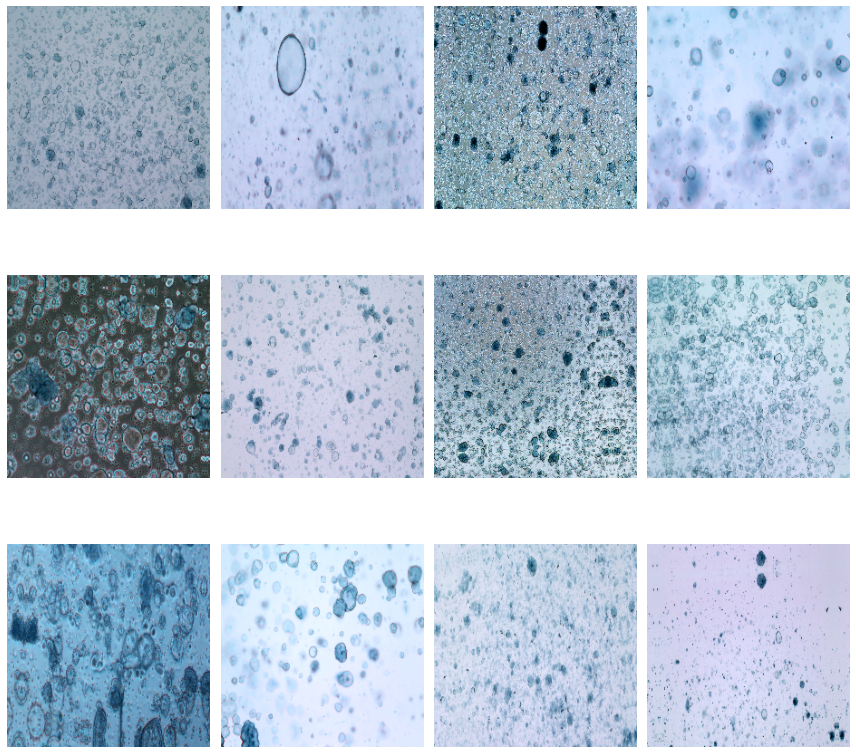

In [34]:
print('Train Set - NonInflamed')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_ni[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

In [35]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [36]:
ds_train = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (IMG_SIZE, IMG_SIZE),
                                                 batch_size = BATCH,
                                                 class_mode = 'binary',
                                                 shuffle=True,
                                                 classes={'NonInflamed': 0., 'Inflamed': 1.}
                                                 )

Found 2998 images belonging to 2 classes.


In [37]:
ds_valid = val_datagen.flow_from_directory(valid_dir,
                                                 target_size = (IMG_SIZE, IMG_SIZE),
                                                 batch_size = BATCH,
                                                 class_mode = 'binary',
                                                 shuffle=True,
                                                 classes={'NonInflamed': 0., 'Inflamed': 1.}
                                                 )

Found 841 images belonging to 2 classes.


In [38]:
ds_test = test_datagen.flow_from_directory(test_dir,
                                                 target_size = (IMG_SIZE, IMG_SIZE),
                                                 batch_size = 1,
                                                 class_mode = 'binary',
                                                 shuffle=False,
                                                 classes={'NonInflamed': 0., 'Inflamed': 1.}
                                                 )

Found 454 images belonging to 2 classes.


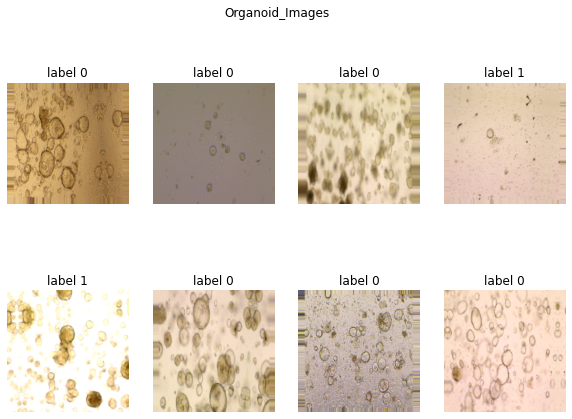

In [39]:
fig, ax = plt.subplots(2, 4, figsize=(10, 7))
fig.suptitle("Organoid_Images")
for k in range(8):
    images, labels = ds_train.next()
    i, j = k//4, k%4
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f'label {int(labels[0])}')
    ax[i, j].axis('off')
plt.show()

In [40]:

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

In [41]:
checkpoint_path = "./checkpoint_path/training_cnn_transfer/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [42]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [43]:
checkpoint = keras.callbacks.ModelCheckpoint('./checkpoint_path/training_cnn_transfer/model{epoch:08d}.h5',save_freq='epoch', period=10) 

In [44]:
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False

def get_pretrained():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

: 

: 

In [ ]:
# Part 3 - Training the CNN

# Compiling the CNN
cnn.compile(optimizer = 'adam', loss = 'hinge', metrics = ['accuracy'])

# Training the CNN on the Training set and evaluating it on the Test set
history = cnn.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_valid,
          callbacks=[cp_callback, checkpoint],
          class_weight = class_weights,
          );